In [1]:
# Cell 1: Imports
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Load Images Function (replace existing cell)

def load_images(hr_path, lr_path, target_lr_size=(128, 128)):
    hr_images = []
    lr_images = []
    
    for i in range(1, 101):
        hr_file = os.path.join(hr_path, f'HR{i:03d}.jpg')
        lr_file = os.path.join(lr_path, f'LR{i:03d}.jpg')
        
        if os.path.exists(hr_file) and os.path.exists(lr_file):
            # Load and resize low-res image to target size
            lr_img = np.array(Image.open(lr_file).resize(target_lr_size)) / 255.0
            
            # Resize high-res image to 4x the low-res dimensions
            hr_size = (target_lr_size[0] * 4, target_lr_size[1] * 4)
            hr_img = np.array(Image.open(hr_file).resize(hr_size)) / 255.0
            
            hr_images.append(hr_img)
            lr_images.append(lr_img)
    
    return np.array(hr_images), np.array(lr_images)

# Load the images with consistent dimensions
hr_path = '../data/highRes'
lr_path = '../data/lowRes'
hr_images, lr_images = load_images(hr_path, lr_path)

# Print shapes to verify dimensions
print(f"Low-res image shape: {lr_images[0].shape}")
print(f"High-res image shape: {hr_images[0].shape}")

# Split dataset
lr_train, lr_test, hr_train, hr_test = train_test_split(
    lr_images, hr_images, test_size=0.2, random_state=42
)

Low-res image shape: (128, 128, 3)
High-res image shape: (512, 512, 3)


In [3]:
# Cell 3: Build Model (replace existing cell)
def build_sr_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, 9, padding='same', activation='relu'),
        layers.Conv2D(32, 5, padding='same', activation='relu'),
        layers.Conv2D(32, 5, padding='same', activation='relu'),
        layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(3, 5, padding='same', activation='sigmoid')
    ])
    return model

# Create and compile model using actual image dimensions
input_shape = lr_images[0].shape
model = build_sr_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 512, 512, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 512, 512, 3)         │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,379 (442.89 KB)

 Trainable params: 113,379 (442.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 832ms/step - loss: 0.0935 - mae: 0.2696 - val_loss: 0.0836 - val_mae: 0.2534
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 807ms/step - loss: 0.0911 - mae: 0.2676 - val_loss: 0.0787 - val_mae: 0.2445
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 765ms/step - loss: 0.0869 - mae: 0.2585 - val_loss: 0.0755 - val_mae: 0.2400
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 0.0776 - mae: 0.2443 - val_loss: 0.0608 - val_mae: 0.2073
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - loss: 0.0690 - mae: 0.2264 - val_loss: 0.0480 - val_mae: 0.1850
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - loss: 0.0503 - mae: 0.1904 - val_loss: 0.0352 - val_mae: 0.1482
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 780ms/step - loss: 0.0356 - mae: 0.1515 - val_loss: 0.0299 - val_mae: 0.1255
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 700ms/step - loss: 0.0274 - mae: 0.1254 - val_loss: 0.0308 - val_mae: 0.1354
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 746ms/step - l

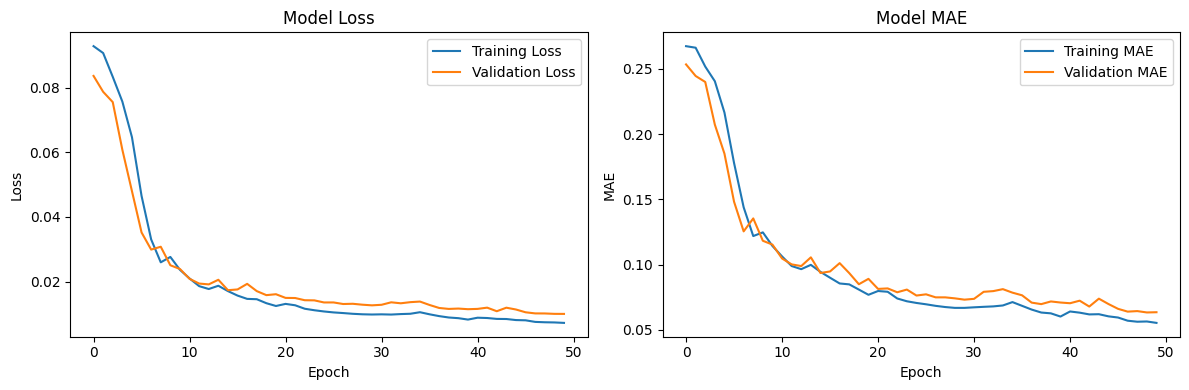

In [4]:
# Cell 4: Train Model
history = model.fit(
    lr_train, hr_train,
    epochs=50,
    batch_size=8,
    validation_data=(lr_test, hr_test),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Cell 5 (Updated): Evaluation Function
def evaluate_and_plot(model, lr_img, hr_img, title="Test Image"):
    sr_img = model.predict(lr_img[np.newaxis, ...])[0]
    
    # Convert to same dtype and ensure float32
    hr_img = hr_img.astype(np.float32)
    sr_img = sr_img.astype(np.float32)
    
    # Calculate metrics
    psnr_value = psnr(hr_img, sr_img, data_range=1.0)
    ssim_value = ssim(hr_img, sr_img, 
                     data_range=1.0,
                     channel_axis=2,  # Specify color channel axis
                     win_size=7)      # Minimum window size
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(lr_img)
    plt.title('Low Resolution')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(hr_img)
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sr_img)
    plt.title(f'Super Resolved\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')
    plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    return psnr_value, ssim_value

Evaluating test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


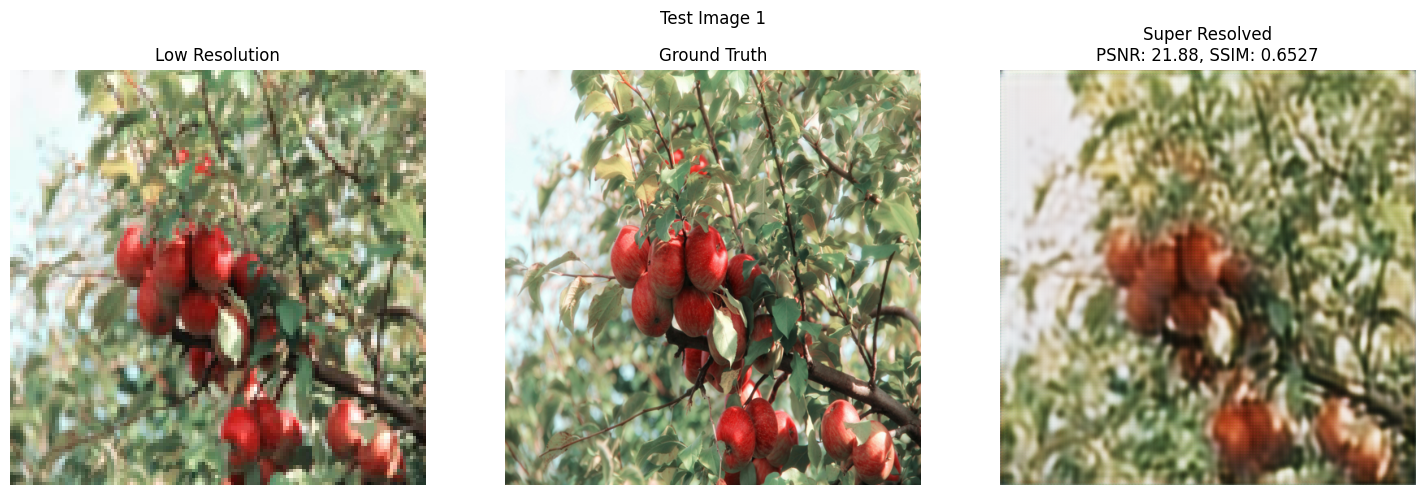

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


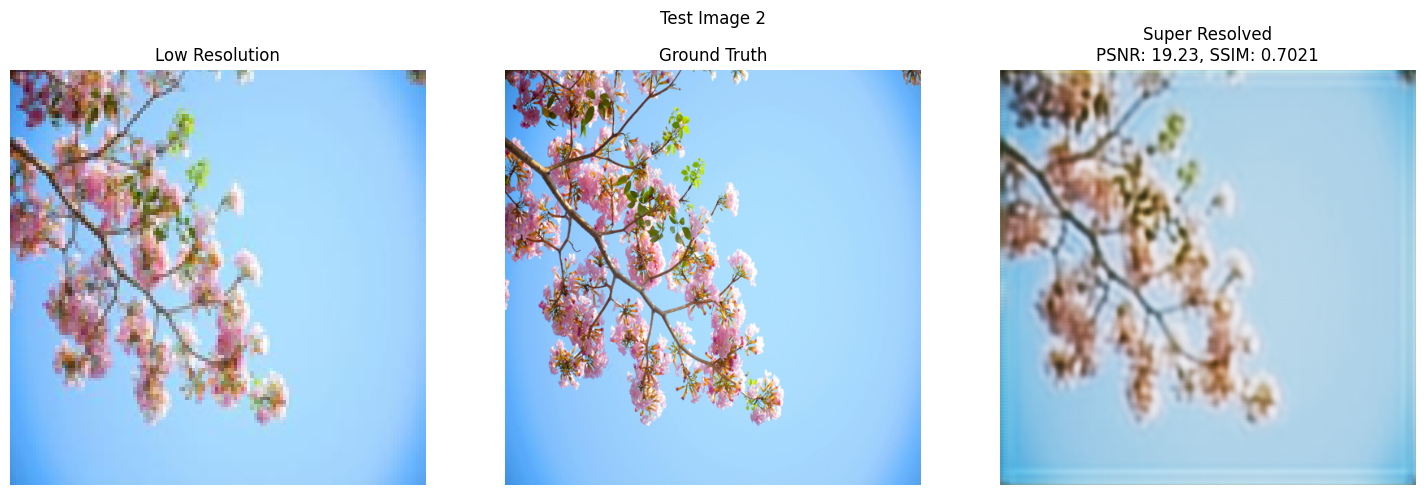

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


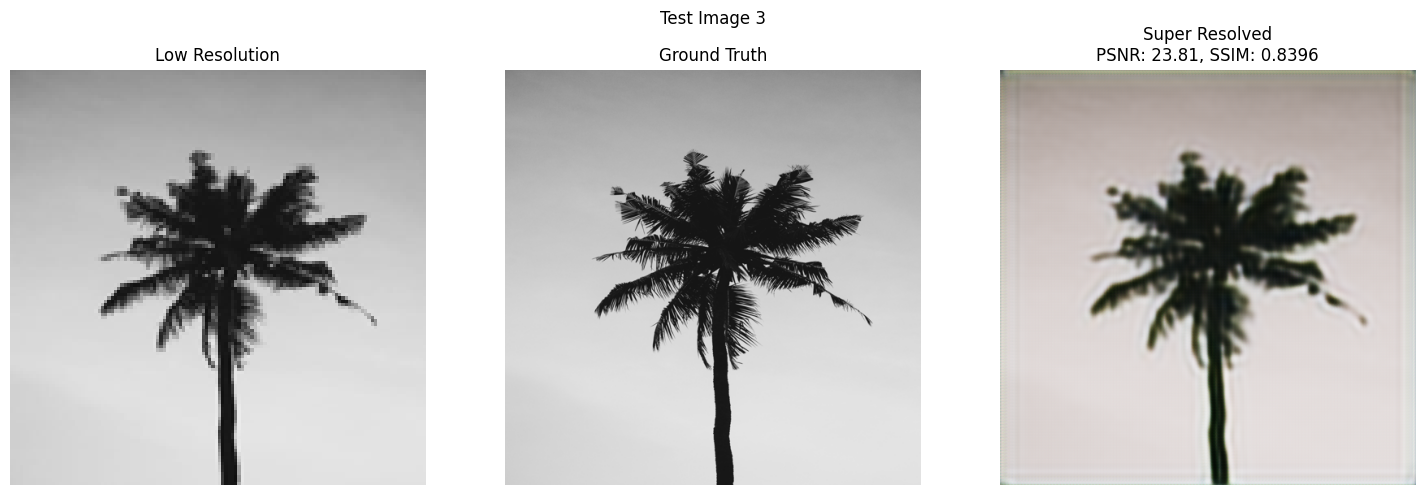

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


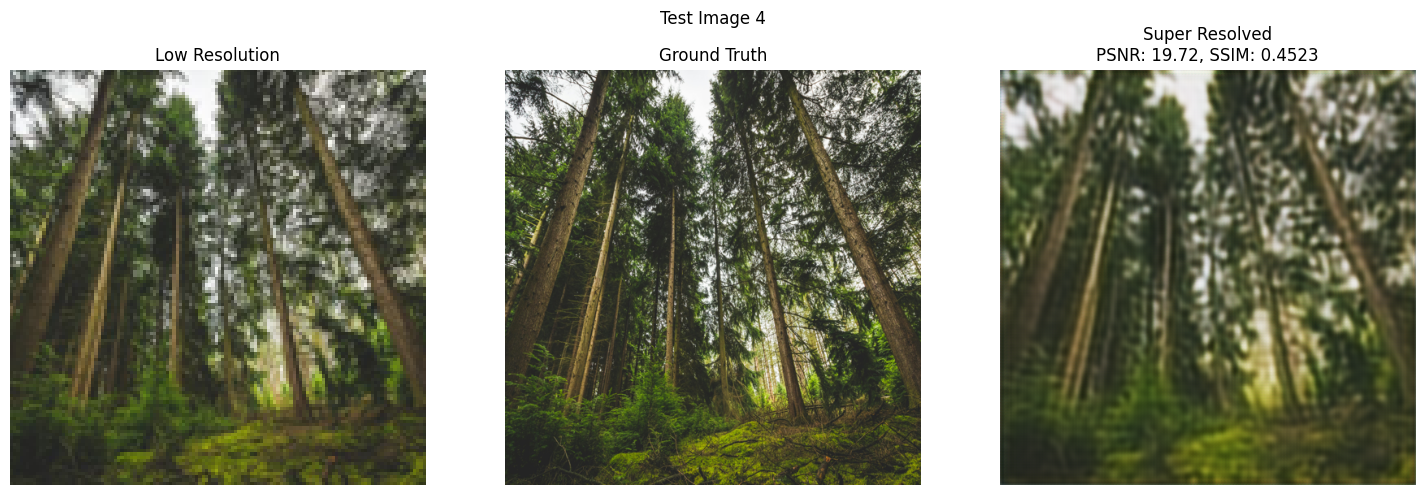

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


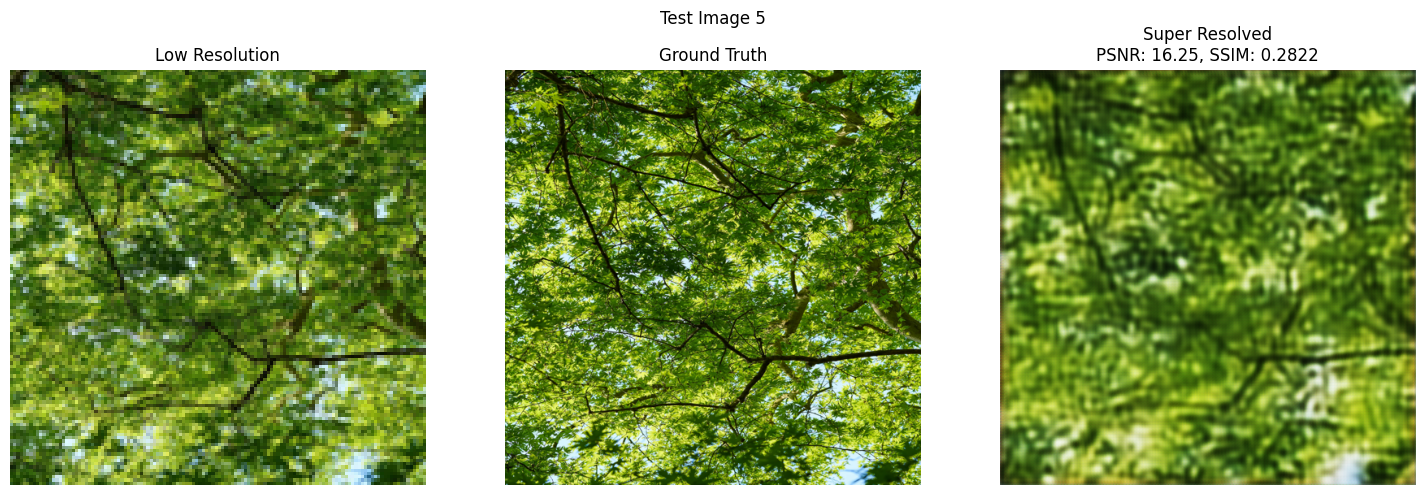


Average PSNR: 20.18 dB
Average SSIM: 0.5858


In [6]:
# Cell 6: Evaluate Test Images
print("Evaluating test images...")
psnr_values = []
ssim_values = []

for i in range(min(5, len(lr_test))):
    psnr_val, ssim_val = evaluate_and_plot(
        model, lr_test[i], hr_test[i], 
        f"Test Image {i+1}"
    )
    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

print(f"\nAverage PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")